# Filter format conversion

Most filters are from SVO. Where theses are not available or we have superior options they may be in different formats and need converting or checking. This notebook is converts filters in non votable form to votable format.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
017bb1e (Mon Jun 18 14:58:59 2018 +0100) [with local modifications]


In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import seaborn.apionly as sns

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.io import ascii
from astropy.io.votable.tree import VOTableFile, Resource, Field
from astropy.io.votable import from_table, writeto

import xml.etree.ElementTree as ET

import time

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

SUFFIX = os.environ.get('SUFFIX', time.strftime("%Y%m%d"))

#filters_folder = "/Users/rs548/GitHub/herschelhelp_python/database_builder/format_changing/"

## Make column headings

In [3]:
filter_names = Table.read("./filters.csv", format='ascii')
filter_names

﻿filter_file,telescope,camera,filter,surveys,description,wavelength_region,ucd
str17,str83,str83,str6,int64,int64,str3,str12
90prime_g.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),g,--,--,opt,B
90prime_r.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),r,--,--,opt,R
90prime_z.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),z,--,--,opt,I
acs_f435w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f435w,--,--,opt,B
acs_f606w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f606w,--,--,opt,R
acs_f775w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f775w,--,--,opt,I
acs_f814w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f814w,--,--,opt,I
acs_f850lp.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f850lp,--,--,opt,I
bessell_b.xml,Standardised telescope response (telescope uknown),Standard camera response (camera unknown),b,--,--,opt,B


In [15]:
intro = """<resource schema="herschelhelp">
  <meta name="title">Herschel Extragalactic Legacy Programme (HELP)</meta>
  <meta name="creationDate">{}</meta>
  <meta name="description">
    HELP master catalogue.
  </meta>
  <meta name="creator.name">Shirley, R.; Roehlly, Y.; et al</meta>

  <meta name="subject">Catalogs</meta>
  <meta name="subject">Galaxies</meta>

  <meta name="coverage">
    <meta name="profile">AllSky ICRS</meta>
    <meta name="waveband">Optical</meta>
    <meta name="waveband">Infrared</meta>
  </meta>

  <meta name="_longdoc" format="rst"> <![CDATA[
    This resource contains the master catalogue from the Herschel Extragalactic
    Legacy Programme (HELP).
    
    History
    -------

    ======== ============================================
    20180530 HELP First data release (DR1)
    ======== ============================================
    
    ======== ============================================
    20180312 Full masterlist DR1 on all HELP fields and bands
    ======== ============================================ 

    ======== ============================================
    20171006 Initial ingestion with ELAIS-N1 prototype.
    ======== ============================================    
    

  ]]></meta>

  <meta name="source"></meta>

  <meta name="_intro" format="rst"> <![CDATA[
    For advanced queries on this catalogue use ADQL_
    possibly via TAP_

    .. _ADQL: /adql
    .. _TAP: /tap
  ]]> </meta>

  <table id="main" onDisk="True" adql="True" mixin="//scs#q3cindex"
      primary="help_id">
    <stc>
      Position ICRS Epoch J2000.0 "ra" "dec"
    </stc>

    <index columns="field" />
    <index columns="help_id" />
    <index columns="ra" />
    <index columns="dec" />
    <index columns="hp_idx" />

    <column name="field"
      tablehead="Field"
      type="text"
      ucd="meta.id;obs.field"
      description="Name of the field in HELP survey"
      required="True"
      verbLevel="1" />
    <column name="help_id"
      tablehead="HELP_Id"
      type="text"
      ucd="meta.id;meta.main"
      description="HELP identifier, based on J2000 position"
      required="True"
      verbLevel="1" />
    <column name="ra"
      tablehead="RA"
      type="double precision"
      ucd="pos.eq.ra;meta.main"
      unit="deg"
      description="Right Ascension (J2000)"
      required="True"
      verbLevel="1" />
    <column name="dec"
      tablehead="Dec"
      type="double precision"
      ucd="pos.eq.dec;meta.main"
      unit="deg"
      description="Declination (J2000)"
      required="True"
      verbLevel="1" />
    <column name="hp_idx"
      tablehead="HP_Idx"
      type="bigint"
      ucd="pos.healpix"
      description="HEALPix index of the source position at order 13 using the nested scheme."
      required="True"
      verbLevel="30" />
    <column name="ebv"
      tablehead="EBV"
      type="double precision"
      ucd="phot.color.excess"
      description="Galactic extinction (Schlegel et al. 1998) at the object position"
      verbLevel="1" />
    <column name="redshift"
      tablehead="Redshift"
      type="real"
      ucd="src.redshift.phot"
      description="Photometric redshift obtained with EAZY."
      verbLevel="1" />
    <column name="zspec"
      tablehead="zSpec"
      type="real"
      ucd="src.redsfhit"
      description="Spectroscopic redshift collated from the literature."
      verbLevel="1" />
    <column name="zspec_qual"
      tablehead="zSpec_qual"
      type="smallint"
      ucd="meta.code.qual;src.redshift"
      description="Spectroscopic redshift quality flag. FIXME code meaning."
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="zspec_association_flag"
      tablehead="zSpec_Association_Flag"
      type="boolean"
      ucd="meta.code;src.redshift"
      description="Boolean flag set to true when the association of a source to it's redshift may be problematic (possible mis-cross-association)."
      verbLevel="1">
        <values nullLiteral="False" />
    </column>
    <column name="stellarity"
      tablehead="stellarity"
      type="real"
      ucd="src.class.starGalaxy"
      description="Index evaluation is the source is point-source: for 0 (not point source) to 1 (point source). Generally name stellarity index."
      verbLevel="1" />
    <column name="stellarity_origin"
      tablehead="stellarity_origin"
      type="text"
      ucd="meta.code;src.class.starGalaxy"
      description="Name of Survey from which stellarity is calculated."
      verbLevel="1" />
      
""".format(SUFFIX)

column_template = """    <column name="f_{band}"
      tablehead="f_{band}"
      type="double precision"
      ucd="phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="Total flux density in the {band_type} band of {camera} on {telescope}."
      verbLevel="1" />
    <column name="ferr_{band}"
      tablehead="ferr_{band}"
      type="double precision"
      ucd="stat.error;phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="Uncertainty on f_{band}."
      verbLevel="1" />
    <column name="f_ap_{band}"
      tablehead="f_ap_{band}"
      type="double precision"
      ucd="phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="Aperture (nearest aperture to 2 arcsec, aperture correction applied) flux density in the {band_type} band of {camera} on {telescope}."
      verbLevel="1" />
    <column name="ferr_ap_{band}"
      tablehead="ferr_ap_{band}"
      type="double precision"
      ucd="stat.error;phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="Uncertainty on f_ap_{band}."
      verbLevel="1" />
    <column name="m_{band}"
      tablehead="m_{band}"
      type="double precision"
      ucd="phot.mag;em.{wavelength_region}.{band_type}"
      unit="mag"
      description="Total AB magnitude in the {band_type} band of {camera} on {telescope}."
      verbLevel="1" />
    <column name="merr_{band}"
      tablehead="merr_{band}"
      type="double precision"
      ucd="stat.error;phot.mag;em.{wavelength_region}.{band_type}"
      unit="mag"
      description="Uncertainty on m_{band}."
      verbLevel="1" />
    <column name="m_ap_{band}"
      tablehead="m_ap_{band}"
      type="double precision"
      ucd="phot.mag;em.{wavelength_region}.{band_type}"
      unit="mag"
      description="Aperture (nearest aperture to 2 arcsec, aperture correction applied) AB magnitude in the {band_type} band of {camera} on {telescope}."
      verbLevel="1" />
    <column name="merr_ap_{band}"
      tablehead="merr_ap_{band}"
      type="double precision"
      ucd="stat.error;phot.mag;em.{wavelength_region}.{band_type}"
      unit="mag"
      description="Uncertainty on m_ap_{band}"
      verbLevel="1" />
    <column name="flag_{band}"
      tablehead="flag_{band}"
      type="boolean"
      ucd="meta.code.qual;em.{wavelength_region}.{band_type}"
      description="Flag set to true for sources for which niether the {band} aperture nor total flux should be used for SED fitting (see documentation)."
      verbLevel="1">
        <values nullLiteral="False" />
    </column>
"""

close = """    <column name="cigale_sfr"
      tablehead="CIGALE_SFR"
      type="double precision"
      ucd="phys.SFR"
      unit="Msun/yr"
      description="Star Formation Rate estimated by SED fitting with CIGALE."
      verbLevel="1" />
    <column name="cigale_sfr_err"
      tablehead="CIGALE_SFR_err"
      type="double precision"
      ucd="stat.error;phys.SFR"
      unit="Msun/yr"
      description="Uncertainty on CIGALE_SFR."
      verbLevel="1" />
    <column name="cigale_mstar"
      tablehead="CIGALE_Mstar"
      type="double precision"
      ucd="phys.mass"
      unit="Msun"
      description="Stellar Mass estimated by SED fitting with CIGALE."
      verbLevel="1" />
    <column name="cigale_mstar_err"
      tablehead="CIGALE_Mstar_err"
      type="double precision"
      ucd="stat.error;phys.mass"
      unit="Msun"
      description="Uncertainty on CIGALE_Mstar"
      verbLevel="1" />
    <column name="cigale_dustlumin"
      tablehead="CIGALE_DustLumin"
      type="double precision"
      ucd="phys.dust;phys.luminosity"
      unit="W"
      description="Dust luminosity estimated by SED fitting with CIGALE using both optical and infra-red information."
      verbLevel="1" />
    <column name="cigale_dustlumin_err"
      tablehead="CIGALE_DustLumin_err"
      type="double precision"
      ucd="stat.error;phys.dust;phys.luminosity"
      unit="W"
      description="Uncertainty on CIGALE_DustLumin."
      verbLevel="1" />
    <column name="cigale_dustlumin_ironly"
      tablehead="CIGALE_DustLumin_IRonly"
      type="double precision"
      ucd="phys.dust;phys.luminosity"
      unit="W"
      description="Dust luminosity estimated by SED fitting with CIGALE using only the infra-red information."
      verbLevel="1" />
    <column name="cigale_dustlumin_ironly_err"
      tablehead="CIGALE_DustLumin_IRonly_err"
      type="double precision"
      ucd="stat.error;phys.dust;phys.luminosity"
      unit="W"
      description="Uncertainty on CIGALE_DustLumin_IRonly"
      verbLevel="1" />
    <column name="flag_cigale"
      tablehead="Flag_CIGALE"
      type="smallint"
      ucd="meta.code.qual"
      description="Flag qualifying the global fitting with CIGALE: 1 for a good fit, 0 for a bad fit, -1 if the source was not fitted."
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="flag_cigale_opt"
      tablehead="Flag_CIGALE_Opt"
      type="smallint"
      ucd="meta.code.qual"
      description="Flag qualifying the fitting of the optical part of the spectrum during the global fit with CIGALE: 1 for a good fit, 0 for a bad fit, -1 if the source was not fitted."
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="flag_cigale_ir"
      tablehead="Flag_CIGALE_IR"
      type="smallint"
      ucd="meta.code.qual"
      description="Flag qualifying the fitting of the infra-red part of the spectrum during the global fit with CIGALE: 1 for a good fit, 0 for a bad fit, -1 if the source was not fitted."
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="flag_cigale_ironly"
      tablehead="Flag_CIGALE_IRonly"
      type="smallint"
      ucd="meta.code.qual"
      description="Flag qualifying the fitting using only infra-red data with CIGALE: 1 for a good fit, 0 for a bad fit, -1 if the source was not fitted."
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>

    <column name="flag_gaia"
      tablehead="Flag_Gaia"
      type="smallint"
      ucd="meta.code"
      description="Flag indicating the increasing probability of the source being a Gaia object (see note)."
      note="1"
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="flag_cleaned"
      tablehead="Flag_Cleaned"
      type="boolean"
      ucd="meta.code"
      description="Boolean flag denoting that the source was associated to really near object that were removed during the cleaning procedure."
      verbLevel="1">
        <values nullLiteral="False" />
    </column>
    <column name="flag_merged"
      tablehead="Flag_Merged"
      type="boolean"
      ucd="meta.code"
      description="Boolean flag denoting a possible mis-association during the cross-matching of the various catalogues."
      verbLevel="1">
        <values nullLiteral="False" />
    </column>
    <column name="flag_optnir_obs"
      tablehead="Flag_OptNIR_Obs"
      type="smallint"
      ucd="meta.code"
      description="Flag indicating in which wavelength regimes the source was observed (see note)."
      note="2"
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>
    <column name="flag_optnir_det"
      tablehead="Flag_OptNIR_Det"
      type="smallint"
      ucd="meta.code"
      description="Flag indicating in which wavelength regimes the source was detected (see note)."
      note="2"
      verbLevel="1">
        <values nullLiteral="-1" />
    </column>

    <meta name="note" tag="1"><![CDATA[
      The Flag_Gaia is computed by cross-matching the catalogue with the Gaia
      catalogue:

      +-------+---------------------------------------------------------------+
      | Value | Meaning                                                       |
      +-------+---------------------------------------------------------------+
      | 1     | The object if possibly a Gaia object: the nearest Gaia source |
      |       | is between 1.5 arcsec and 2 arcsec.                           |
      +-------+---------------------------------------------------------------+
      | 2     | The object if probably a Gaia object: the nearest Gaia source |
      |       | is between 0.6 arcsec and 1.5 arcsec.                         |
      +-------+---------------------------------------------------------------+
      | 3     | The object is definitely a Gaia object: the nearest Gaia      |
      |       | source is nearer than 0.6 arcsec.                             |
      +-------+---------------------------------------------------------------+
      | 0     | Otherwise (the nearest Gaia source is farer than 2 arcsec).   |
      +-------+---------------------------------------------------------------+

      ]]></meta>
    <meta name="note" tag="2"><![CDATA[
      The Flag_OptNIR_Obs and Flag_OptNIR_Det are computed while cross-matching
      the optical and near/mid infrared catalogues and indicate if a source was
      observed (i.e. is on the coverage of surveys at the given regime) or
      detected (i.e. is present in the catalogue) in various wavelength regime.
      The detection is based on the detection wavelengths of the catalogues, and
      to be counted as detected, a source must be present in at least two
      catalogues.

      The flag is a composed binary flag with these values:

      +-------+-------------------------------------------------------------+
      | Value | Meaning                                                     |
      +-------+-------------------------------------------------------------+
      | 1     | Observation/detection in optical wavelengths.               |
      +-------+-------------------------------------------------------------+
      | 2     | Observation/detection in near-infrared wavelengths.         |
      +-------+-------------------------------------------------------------+
      | 4     | Observation/detection in mid-infrared wavelengths.          |
      +-------+-------------------------------------------------------------+

      ]]></meta>
  </table>

  <data id="import">
    <sources>
      <pattern>data/main/*.csv</pattern>
    </sources>
    <csvGrammar />
    <make table="main">
      <rowmaker idmaps="*">
        <simplemaps></simplemaps>
      </rowmaker>
    </make>
  </data>

  <service id="cone" allowed="scs.xml,form,static">
    <meta name="title">HELP main catalogue</meta>
    <meta name="shortName">HELP main</meta>
    <meta name="testQuery">
      <meta name="ra">150.1</meta>
      <meta name="dec">2.218</meta>
      <meta name="sr">1.0</meta>
    </meta>

    <!-- this is to allow access to the raw data.  Decide for yourself
    whether or not you want this -->
    <property name="staticData">data/files</property>

    <dbCore queriedTable="main">
      <FEED source="//scs#coreDescs"/>
      <condDesc buildFrom="field" />
      <condDesc buildFrom="help_id" />
    </dbCore>

    <publish render="scs.xml" sets="ivo_managed"/>
    <publish render="form" sets="ivo_managed,local"/>
    <outputTable verbLevel="20"/>
  </service>

</resource>

<!--
vim:et:sta:sw=2
-->"""

In [16]:
column_heads = open('columns.xml', 'w+')

column_heads.write(intro)
for f in filter_names:
    column_heads.write(column_template.format(band     = f[0].replace('.xml',''),
                                             band_type = f[7],
                                             camera    = f[2],
                                             telescope = f[1],
                                            wavelength_region = f[6]
                                             )
                      )
    #print(f[0].replace('.xml',''))
    
column_heads.write(close)
    
column_heads.close()


## Column headings for depth maps

In [11]:
intro = """<resource schema="depth">
  <meta name="title">HELP depth values</meta>
  <meta name="creationDate">{}</meta>
  <meta name="description">
    HELP depth values in various bands associated to HEALPix cells.
  </meta>
  <meta name="creator.name">Shirley, R.; Roehlly, Y.;  et al</meta>

  <meta name="subject">Catalogs</meta>
  <meta name="subject">Depth</meta>

  <meta name="coverage">
    <meta name="profile">AllSky ICRS</meta>
    <meta name="waveband">Infrared</meta>
  </meta>

  <meta name="_longdoc" format="rst"> <![CDATA[

    This resource contains the depth information for the HELP data. For each
    band (or equivalent, e.g. spectroscopic redsfhit) we store depth values
    (generally the limiting magnitude) associated with HEALPix cells identified
    by a HEALPix order and NPix. The HEALPix cells are expressed in equatorial
    coordinates (ICRS reference) and use the nested numbering scheme.

    History
    -------
    
    ======== ============================================
    20180530 HELP First data release (DR1)
    ======== ============================================

    ======== ============================================
    20161208 Initial ingestion with test K depth data.
    ======== ============================================

  ]]> </meta>

  <table id="main" onDisk="True" adql="True">
  
""".format(SUFFIX)

      



column_template = """    <column name="ferr_{band}_mean"
      tablehead="ferr_{band}_mean"
      type="double precision"
      ucd="stat.error;phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="The mean uncertainty on ferr_{band} in the order 10 healpix pixel that contains this order 13 healpix pixel."
      verbLevel="1" />
    <column name="ferr_ap_{band}_mean"
      tablehead="ferr_{band}_mean"
      type="double precision"
      ucd="stat.error;phot.flux;em.{wavelength_region}.{band_type}"
      unit="uJy"
      description="The mean uncertainty on f_ap_{band} for all objects in the order 10 healpix pixel that contains this order 13 healpic pixel."
      verbLevel="1" />

"""


close = """  </table>
  <data id="import">
    <sources>
      <pattern>data/*.csv</pattern>
    </sources>
    <csvGrammar />
    <make table="main">
      <rowmaker idmaps="*" />
    </make>
  </data>

</resource>

<!--
vim:et:sta:sw=2
-->"""

In [12]:
filter_names

﻿filter_file,telescope,camera,filter,surveys,description,wavelength_region,ucd
str17,str83,str83,str6,int64,int64,str3,str12
90prime_g.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),g,--,--,opt,B
90prime_r.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),r,--,--,opt,R
90prime_z.xml,The Bok Telescope,The 90-inch prime focus camera (90prime),z,--,--,opt,I
acs_f435w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f435w,--,--,opt,B
acs_f606w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f606w,--,--,opt,R
acs_f775w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f775w,--,--,opt,I
acs_f814w.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f814w,--,--,opt,I
acs_f850lp.xml,Hubble Space Telescope (HST),Advanced Camera for Surveys (ACS),f850lp,--,--,opt,I
bessell_b.xml,Standardised telescope response (telescope uknown),Standard camera response (camera unknown),b,--,--,opt,B


In [17]:
index_column_template = """
    <index columns="ferr_{band}_mean" />
    <index columns="ferr_ap_{band}_mean" />
""" 
index_columns =""
for f in filter_names:
    if ('spire' not in f[0]) and ('pacs' not in f[0]) and ('mips' not in f[0]) and ('_ap_' not in f[0]):
        index_columns += index_column_template.format(band = f[0].replace('.xml',''))
        
index_section = """
    <index columns="hp_idx_O_13" />
    <index columns="hp_idx_O_10" />
{index_columns}
    

    <column name="hp_idx_O_13"
      tablehead="HEALPix_Npix_O13"
      type="bigint"
      ucd="pos.healpix"
      description="HEALPix cell index at order 13."
      required="True"
      verbLevel="1" />
    <column name="hp_idx_O_10"
      tablehead="HEALPix_Npix_O10"
      type="bigint"
      ucd="pos.healpix"
      description="HEALPix cell index at order 10. This was the pixel order used to compute the means"
      required="True"
      verbLevel="1" />
""".format(index_columns=index_columns)

In [18]:
column_heads = open('depth_columns.xml', 'w+')
column_heads.write(intro)
column_heads.write(index_section)
for f in filter_names:
    if ('spire' not in f[0]) and ('pacs' not in f[0]) and ('mips' not in f[0]) and ('_ap_' not in f[0]):
        column_heads.write(column_template.format(band     = f[0].replace('.xml',''),
                                             band_type = f[7],
                                             camera    = f[2],
                                             telescope = f[1],
                                            wavelength_region = f[6]
                                             )
                          )
column_heads.write(close)
    
column_heads.close()

## Make yml and csv for columns

In [17]:
tree = ET.parse('columns.xml').getroot()

In [18]:
for atype in tree.iter('column'):
    print(atype.get("name"), 
          atype.get("tablehead"), 
          atype.get("type"), 
          atype.get("ucd"),
          atype.get( "description"), 
          atype.get('ucd'))

field Field text meta.id;obs.field Name of the field in HELP survey meta.id;obs.field
help_id HELP_Id text meta.id;meta.main HELP identifier, based on J2000 position meta.id;meta.main
ra RA double precision pos.eq.ra;meta.main Right Ascension (J2000) pos.eq.ra;meta.main
dec Dec double precision pos.eq.dec;meta.main Declination (J2000) pos.eq.dec;meta.main
hp_idx HP_Idx bigint pos.healpix HEALPix index of the source position at order 13 using the nested scheme. pos.healpix
ebv EBV double precision phot.color.excess Galactic extinction (Schlegel et al. 1998) at the object position phot.color.excess
redshift Redshift real src.redshift.phot Photometric redshift obtained with EAZY. src.redshift.phot
zspec zSpec real src.redsfhit Spectroscopic redshift collated from the literature. src.redsfhit
zspec_qual zSpec_qual smallint meta.code.qual;src.redshift Spectroscopic redshift quality flag. FIXME code meaning. meta.code.qual;src.redshift
zspec_association_flag zSpec_Association_Flag boolean me

flag_gpc1_i flag_gpc1_i boolean meta.code.qual;em.opt.I Flag set to true for sources for which niether the gpc1_i aperture nor total flux should be used for SED fitting (see documentation). meta.code.qual;em.opt.I
f_gpc1_r f_gpc1_r double precision phot.flux;em.opt.R Total flux density in the R band of The Pan-STARRS Gigapixel Camera on The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS). phot.flux;em.opt.R
ferr_gpc1_r ferr_gpc1_r double precision stat.error;phot.flux;em.opt.R Uncertainty on f_gpc1_r. stat.error;phot.flux;em.opt.R
f_ap_gpc1_r f_ap_gpc1_r double precision phot.flux;em.opt.R Aperture (nearest aperture to 2 arcsec, aperture correction applied) flux density in the R band of The Pan-STARRS Gigapixel Camera on The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS). phot.flux;em.opt.R
ferr_ap_gpc1_r ferr_ap_gpc1_r double precision stat.error;phot.flux;em.opt.R Uncertainty on f_ap_gpc1_r. stat.error;phot.flux;em.opt.R
m_gpc1_r m_gpc1_r double p

flag_omega2000_j flag_omega2000_j boolean meta.code.qual;em.opt.J Flag set to true for sources for which niether the omega2000_j aperture nor total flux should be used for SED fitting (see documentation). meta.code.qual;em.opt.J
f_omega2000_ks f_omega2000_ks double precision phot.flux;em.IR.K Total flux density in the K band of The Infrared Wide-Field Camera OMEGA2000 on The 3.5m telescope at Calar Alto. phot.flux;em.IR.K
ferr_omega2000_ks ferr_omega2000_ks double precision stat.error;phot.flux;em.IR.K Uncertainty on f_omega2000_ks. stat.error;phot.flux;em.IR.K
f_ap_omega2000_ks f_ap_omega2000_ks double precision phot.flux;em.IR.K Aperture (nearest aperture to 2 arcsec, aperture correction applied) flux density in the K band of The Infrared Wide-Field Camera OMEGA2000 on The 3.5m telescope at Calar Alto. phot.flux;em.IR.K
ferr_ap_omega2000_ks ferr_ap_omega2000_ks double precision stat.error;phot.flux;em.IR.K Uncertainty on f_ap_omega2000_ks. stat.error;phot.flux;em.IR.K
m_omega2000_ks 

flag_suprime_zp flag_suprime_zp boolean meta.code.qual;em.opt.I Flag set to true for sources for which niether the suprime_zp aperture nor total flux should be used for SED fitting (see documentation). meta.code.qual;em.opt.I
f_suprime_zpp f_suprime_zpp double precision phot.flux;em.opt.I Total flux density in the I band of SuprimeCam on The Subaru telescope. phot.flux;em.opt.I
ferr_suprime_zpp ferr_suprime_zpp double precision stat.error;phot.flux;em.opt.I Uncertainty on f_suprime_zpp. stat.error;phot.flux;em.opt.I
f_ap_suprime_zpp f_ap_suprime_zpp double precision phot.flux;em.opt.I Aperture (nearest aperture to 2 arcsec, aperture correction applied) flux density in the I band of SuprimeCam on The Subaru telescope. phot.flux;em.opt.I
ferr_ap_suprime_zpp ferr_ap_suprime_zpp double precision stat.error;phot.flux;em.opt.I Uncertainty on f_ap_suprime_zpp. stat.error;phot.flux;em.opt.I
m_suprime_zpp m_suprime_zpp double precision phot.mag;em.opt.I Total AB magnitude in the I band of Supri

In [19]:
column_csv = open('columns.csv', 'w+')
column_csv.write('Column, Name, Type, Unit, Description, UCD \n')
for atype in tree.iter('column'):
    column_csv.write("{}, {}, {}, {}, \"{}\", {} \n".format( 
          atype.get("name"), 
          atype.get("tablehead"), 
          atype.get("type"), 
          atype.get("unit"), 
          atype.get("description"), 
          atype.get("ucd")
                   ))
    
column_csv.close()

In [20]:
yml_base = """{}: 
  tablehead: {}
  type: {}
  unit: {}
  description: "{}"
  ucd: {}

"""

column_yml = open('columns.yml', 'w+')

for atype in tree.iter('column'):
    column_yml.write(yml_base.format( 
          atype.get("name"), 
          atype.get("tablehead"), 
          atype.get("type"), 
          atype.get("unit"),
          atype.get("description"), 
          atype.get("ucd")
                   ))
    
column_yml.close()

# Convert file formats

Perhaps we should also correct filters that do not include QE and atmosphere here.

## Mosaic Ks

In [4]:
mosaic_ks = ascii.read('./format_changing/mosaic_ks.txt')

In [5]:
mosaic_ks[:10]

col1,col2
float64,float64
1.9,0.0
1.91,0.005
1.92,0.015
1.93,0.05
1.94,0.16
1.95,0.55
1.96,0.91
1.97,0.95
1.98,0.96


In [6]:
mosaic_ks['col1'].name = 'Wavelength'
# Convert units to angstroms
mosaic_ks['Wavelength'] = mosaic_ks['Wavelength']*1.e4
mosaic_ks['Wavelength'].unit = u.angstrom
mosaic_ks['col2'].name = 'Transmission'
mosaic_ks.meta["Description"] = 'Ks Mosaic'
mosaic_ks.meta["Band"] = 'Ks'
mosaic_ks.meta["Facility"] = 'KPNO'
mosaic_ks.meta["Instrument"] = 'Mosaic'
# Required meta

In [7]:
mosaic_ks[:10]

Wavelength,Transmission
Angstrom,
float64,float64
19000.0,0.0
19100.0,0.005
19200.0,0.015
19300.0,0.05
19400.0,0.16
19500.0,0.55
19600.0,0.91
19700.0,0.95


In [8]:
writeto(mosaic_ks, './filters/mosaic_ks.xml')

In [9]:
mosaic_b = ascii.read('./format_changing/mosaic_b.dat')
mosaic_b['col1'].name = 'Wavelength'
mosaic_b['Wavelength'].unit = u.angstrom
mosaic_b['col2'].name = 'Transmission'
#Convert percent to fraction
mosaic_b['Transmission'] = mosaic_b['Transmission']*1.e-2
#mosaic_b
mosaic_b.meta["Description"] = 'Bw Mosaic k1025'
mosaic_b.meta["Band"] = 'Bw'
mosaic_b.meta["Facility"] = 'KPNO'
mosaic_b.meta["Instrument"] = 'Mosaic'

In [10]:
mosaic_b[:10]

Wavelength,Transmission
Angstrom,
float64,float64
3200.0,-0.0001
3202.0,-0.00015
3204.0,-5e-05
3206.0,0.0001
3208.0,-0.0001
3210.0,-0.00015
3212.0,-0.0001
3214.0,-0.0002


In [11]:
writeto(mosaic_b, './filters/mosaic_b.xml')

## Suprime narrow

Filters downloaded from http://cosmos.astro.caltech.edu/page/filterset

For some reason teh same filter is sometimes always labelled IB and sometimes ia or ib. We follow the convention in the COSMOS2015 paper.

|name in COSMOS2015| name in HELP    | Name on download page |
|:-----------------|:----------------|:----------------------|
| ia484            | suprime_ia484   | IB484                 |
| ia527            | suprime_ia527   | IB527                 |
| ia624            | suprime_ia624   | IB624                 |
| ia679            | suprime_ia679   | IB679                 |
| ia738            | suprime_ia738   | IB738                 |
| ia767            | suprime_ia767   | IB767                 |
| ib427            | suprime_ib427   | IB427                 |
| ib464            | suprime_ib464   | IB464                 |
| ib505            | suprime_ib505   | IB505                 |
| ib574            | suprime_ib574   | IB574                 |
| ib709            | suprime_ib709   | IB709                 |
| ib827            | suprime_ib827   | IB827                 |

In [12]:
suprime_filters = [
    'ia484',
    'ia527',
    'ia624',
    'ia679',
    'ia738',
    'ia767',
    'ib427',
    'ib464',
    'ib505',
    'ib574',
    'ib709',
    'ib827'
]


In [13]:
sup_test = ascii.read('./format_changing/IB427.SuprimeCam.pb')
sup_test[:10].show_in_notebook()
sup_test.meta

OrderedDict([('comments',
              ['filter: IB427',
               'instrument: SuprimeCam',
               'description: Telescope + CCD + filter + atmosphere',
               'reference: None',
               'comment: Filter Passband from S. Sasaki web page, file IB3_07.txt',
               'comment: CCD and Optics transmission derived from the filter curves',
               'comment: at http://indus.astron.s.u-tokyo.ac.jp/works/suprime/filters/',
               'comment: Litterature inband flux at 0 mag and bandwidth computed from bandpass',
               'comment: Prepared by H. Aussel (herve dot aussel at cea dot fr)',
               'url: http://cosmos.phys.sci.ehime-u.ac.jp/~sasaki/NB+IA_FILTER/filter.html',
               'system: ab',
               'primary standard: abstd',
               'primary magnitude: 0.0',
               'bandwidth (xunit): 195.80568365897',
               'inband flux at 0 mag: 1.17279863299192E-09',
               'airmass: 1.2',
          

In [16]:
for f in suprime_filters:
    tab = ascii.read('./format_changing/{}.SuprimeCam.pb'.format(f.upper()))
    tab['file:'].name = 'Wavelength'
    tab['Wavelength'].unit = u.angstrom
    tab['{}.SuprimeCam.pb'.format(f.replace('a','b').upper())].name = 'Transmission'
    tab.meta["Description"] = 'Suprime {}'.format(f)
    tab.meta["Band"] = f
    tab.meta["Facility"] = 'Subaru'
    writeto(tab, './filters/suprime_{}.xml'.format(f.lower()))

For Suprime zp we have teh option of using the SVO one and doubling it or taking the download and converting. 

In [36]:
suprime_zp = ascii.read('./format_changing/suprime_zp.res')
suprime_zp['col1'].name = 'Wavelength'
suprime_zp['Wavelength'].unit = u.angstrom
suprime_zp['col2'].name = 'Transmission'
#Use over SVO doubles?
writeto(tab, './filters/suprime_zp.xml')

In [37]:
suprime_zpp = ascii.read('./format_changing/suprime_zpp.res')
suprime_zpp['col1'].name = 'Wavelength'
suprime_zpp['Wavelength'].unit = u.angstrom
suprime_zpp['col2'].name = 'Transmission'
#Use over SVO doubles?
writeto(tab, './filters/suprime_zp.xml')

In [39]:
svo_suprime_zp = Table(data = parse_single_table('./format_changing/SVO_suprime_zp.xml').array.data)

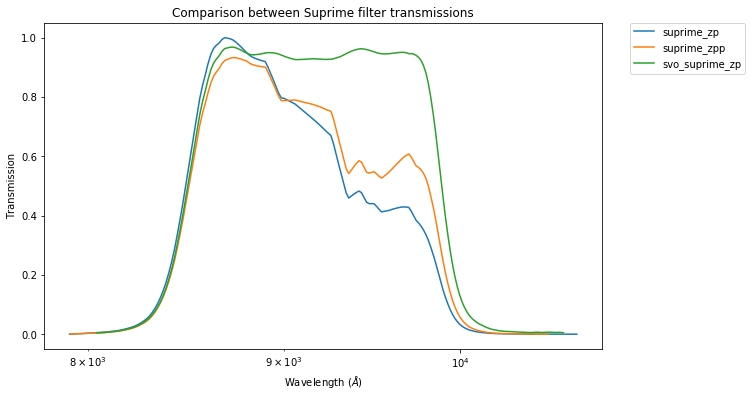

In [40]:
plt.plot(suprime_zp['Wavelength'],suprime_zp['Transmission'], label='suprime_zp')

plt.plot(suprime_zpp['Wavelength'],suprime_zpp['Transmission'], label='suprime_zpp')

plt.plot(svo_suprime_zp['Wavelength'],svo_suprime_zp['Transmission'], label='svo_suprime_zp')

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Transmission')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison between Suprime filter transmissions')

It looks like the SVO filters don't include atmospheric correction so we use the downloaded conversions

### Hawaii QUIRC instrument HK

In [41]:
quirc_hk = ascii.read('./format_changing/quirc_hk.txt')
quirc_hk['col1'].name = 'Wavelength'
quirc_hk['Wavelength'] *= 10000.
quirc_hk['Wavelength'].unit = u.angstrom
quirc_hk['col2'].name = 'Transmission'



In [42]:
quirc_hk['Wavelength'][:10]

13900.0
14000.0
14100.0
14200.0
14300.0
14400.0
14500.0
14600.0
14700.0
14800.0


In [43]:
writeto(tab, './filters/quirc_hk.xml')